In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import classification_report

# CLS

# `compute_distance_sums` Function

The `compute_distance_sums` function calculates the cumulative distance between a given test image embedding and a set of stored memory embeddings. The computed distances are aggregated based on class labels, providing a per-class similarity score.

## Parameters

- **selected_test_image_embedding** (`numpy array`): The embedding vector of the test image.
- **memory_embeddings** (`list of numpy arrays`): A collection of embeddings stored in memory.
- **memory_labels** (`list of int`): Class labels corresponding to `memory_embeddings`.
- **predicted_softmax_label** (`numpy array`, optional): A probability distribution over classes, from the finetuned model.
- **static_distance** (`float`, default=`1`): A scaling factor applied to `predicted_softmax_label`.
- **distance_metric** (`str`, default=`'cosine'`): Specifies the distance metric to use. Options:
  - `'cosine'`: Uses cosine similarity.
  - `'euclidean'`: Uses a modified Euclidean distance (`1 / (1 + d)`).
- **num_classes** (`int`, default=`10`): Total number of possible classes.

## Returns

- **distance_sums** (`numpy array`): An array of length `num_classes`, where each index represents the cumulative similarity score for that class.

## Methodology

### 1. One-Hot Encoding of Labels
- A one-hot encoded matrix of shape `(len(memory_labels), num_classes)` is created to represent the class labels.
- If any label is out of range, an error is raised.

### 2. Distance Computation
- Each memory embedding is compared to the `selected_test_image_embedding` using the specified `distance_metric`.
  - **Cosine similarity** is used if `distance_metric='cosine'`.
  - A **normalized Euclidean distance** (`1 / (1 + d)`) is used if `distance_metric='euclidean'`.
- The computed distance is multiplied by the corresponding one-hot encoded label and added to `distance_sums`.

### 3. Adjustment Using Softmax Prediction
- If `predicted_softmax_label` is provided, it is scaled by `static_distance` and added to `distance_sums`.

In [4]:
def compute_distance_sums(selected_test_image_embedding, memory_embeddings, memory_labels, predicted_softmax_label= None, static_distance = 1, distance_metric='cosine', num_classes=10):

    distance_sums = np.zeros(num_classes)

    # Initialize the one-hot vectors based on memory_labels
    memory_labels_onehot = np.zeros((len(memory_labels), num_classes))

    # Create the one-hot encoding for each memory label
    for i, label in enumerate(memory_labels):
        if label < num_classes:
            memory_labels_onehot[i, label] = 1
        else:
            raise ValueError(f"Label {label} is out of range. Expected between 0 and {num_classes - 1}.")

    # Loop over each memory embedding and compute distances
    for i, memory_embedding in enumerate(memory_embeddings):
        # One-hot encode the memory label
        memory_label_onehot = memory_labels_onehot[i]
        
        # When two embeddings are identical the cosine = 1 and the Euclidean is 0
        # when two embeddings are very different then cosine = -1 and euclidean = inf
        # Compute the 1/(1+d) for Euclidean in order to be 1 for identical and 0 for very different,
        # Compute the distance (Cosine or Euclidean based on the parameter)
        if distance_metric == 'cosine':
            dist = cosine_similarity([selected_test_image_embedding], [memory_embedding])[0][0]
        elif distance_metric == 'euclidean':
            dist = 1/(1+euclidean_distances([selected_test_image_embedding], [memory_embedding])[0][0]) # 1/(1+d)
        else:
            raise ValueError("Unsupported distance metric. Choose 'cosine' or 'euclidean'.")
        
        # print(f'######Iteration {i}#########')
        # print(memory_labels[i])
        # print(memory_label_onehot)
        # print(dist)
        # print(f'Before: {distance_sums}')
        # Add the distance to the initialized array
        distance_sums += memory_label_onehot * dist
        # print(f'After: {distance_sums}')
        # print('###############')

    
    # Final calculation based on the distance metric
    if predicted_softmax_label is not None:
        # print('########## Final #########')
        
        # Add the predicted value weighted by static distance
        distance_sums += predicted_softmax_label * static_distance
        
        # print(predicted_softmax_label * static_distance)
        # print(f'Final: {distance_sums}')

    return distance_sums

# `get_predicted_class` Function

The `get_predicted_class` function determines the predicted class based on the cumulative similarity scores (`distance_sums`) computed by the `compute_distance_sums` function.

In [5]:
def get_predicted_class(distance_sums):
    index = np.argmax(distance_sums)
    return index

# `load_data_cls` Function

The `load_data_cls` function loads data from a `.npz` file, which contains test and neighbor class embeddings along with their corresponding labels.

In [146]:
def load_data_cls(file_path: str):
    # Load the .npz file
    data = np.load(file_path)

    # for key in data.keys():
    #     print(f"{key}: {data[key].shape}")
    
    # Extract the arrays
    test_cls = data['test_cls']
    test_labels = data['test_labels']
    neighbor_cls = data['neighbor_cls']
    neighbor_labels = data['neighbor_labels']
    print("Data loaded successfully.")
    
    return test_cls, test_labels, neighbor_cls, neighbor_labels

# `load_softmax_predictions` Function

The `load_softmax_predictions` function loads softmax predictions from a `.npz` file. These predictions represent the probability distribution over classes for a set of inputs.

In [6]:
def load_softmax_predictions(file_path: str):
    # Load the .npz file
    data = np.load(file_path)
    predicted_softmax_labels= data['predictions']
    return predicted_softmax_labels

In [7]:
predicted_softmax_file_path = f"output_data/vit_tiny_softmax_predictions_CIFAR10.npz"
predicted_softmax_labels = load_softmax_predictions(predicted_softmax_file_path)

# Processing CLS Embeddings with Distance Metrics

This script processes class embeddings using a specified distance metric (`cosine` or `euclidean`) and evaluates the performance of the predictions.

In [152]:
k_list = [3,5,7,9,11,13,15,17,19]
use_softmax_predictions = False

for k in k_list:
    print(f'Processing k={k}')
    file_path = f"output_data/cls/cls_neighbors_euclidean_{k}.npz"  # Specify the file path
    test_embeddings, test_labels, all_memory_embeddings, all_memory_labels = load_data_cls(file_path)
    num_classes = len(np.unique(test_labels, return_counts=False))

    print(f"Test CLS: {test_embeddings.shape}, Type: {type(test_embeddings)}")
    print(f"Test Labels: {test_labels.shape}, Type: {type(test_labels)}")
    print(f"Neighbor CLS: {all_memory_embeddings.shape}, Type: {type(all_memory_embeddings)}")
    print(f"Neighbor Labels: {all_memory_labels.shape}, Type: {type(all_memory_labels)}")
    print(f"Distince Number of Classes: {num_classes}")

    # For CLS
    y_pred = []

    distance_metric='cosine'
    #distance_metric='euclidean'

    for selected_test_image_embedding, memory_embeddings, memory_labels, predicted_softmax_label in zip(test_embeddings, all_memory_embeddings, all_memory_labels, predicted_softmax_labels):
        #print(memory_labels)
        if use_softmax_predictions:
            distance_sums = compute_distance_sums(selected_test_image_embedding, memory_embeddings, memory_labels, predicted_softmax_label= predicted_softmax_label, static_distance = 1, distance_metric=distance_metric, num_classes=num_classes)
        else:
            distance_sums = compute_distance_sums(selected_test_image_embedding, memory_embeddings, memory_labels, predicted_softmax_label= None, static_distance = 1, distance_metric=distance_metric, num_classes=num_classes)
        predicted_class = get_predicted_class(distance_sums)
        y_pred.append(predicted_class)
        #break

    # Compute accuracy
    print(classification_report(test_labels, y_pred))

Processing k=3
Data loaded successfully.
Test CLS: (10000, 192), Type: <class 'numpy.ndarray'>
Test Labels: (10000,), Type: <class 'numpy.ndarray'>
Neighbor CLS: (10000, 3, 192), Type: <class 'numpy.ndarray'>
Neighbor Labels: (10000, 3), Type: <class 'numpy.ndarray'>
Distince Number of Classes: 10
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1000
           1       0.70      0.70      0.70      1000
           2       0.76      0.53      0.62      1000
           3       0.53      0.49      0.51      1000
           4       0.67      0.66      0.67      1000
           5       0.58      0.58      0.58      1000
           6       0.67      0.82      0.74      1000
           7       0.71      0.76      0.73      1000
           8       0.76      0.77      0.77      1000
           9       0.65      0.75      0.70      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     100

# Patch

# `process_lists` Function

The `process_lists` function processes a list of lists by either summing or averaging the elements along the columns. It supports both Python lists and NumPy arrays as input.

In [8]:
def process_lists(lists, mode="sum"):
    if not isinstance(lists, list):
        raise ValueError("Input must be a list of lists.")
    
    lists = [lst.tolist() if isinstance(lst, np.ndarray) else lst for lst in lists]
    
    if not all(isinstance(lst, list) for lst in lists):
        raise ValueError("Each element in the input must be a list.")
    
    if mode not in {"sum", "average"}:
        raise ValueError("Mode must be 'sum' or 'average'.")

    # Convert to NumPy array for vectorized operations
    array = np.array(lists)
    
    if mode == "sum":
        processed = np.sum(array, axis=0)
    else:  # mode == "average"
        processed = np.mean(array, axis=0)
    
    return processed.tolist()  # Return as a list

# `load_data_patch` Function

The `load_data_patch` function loads data from a `.npz` file, which contains test and neighbor class embeddings along with their corresponding labels for patch related info.

In [9]:
def load_data_patch(file_path: str):
    # Load the .npz file
    data = np.load(file_path)
    
    # Extract the arrays
    test_patch = data['test_patch']
    test_labels = data['test_labels']
    neighbor_patch = data['neighbor_path']
    neighbor_labels = data['neighbor_labels']
    print("Data loaded successfully.")
    
    return test_patch, test_labels, neighbor_patch, neighbor_labels

In [10]:
file_path = f"output_data/patch/patch_memory_euclidian.npz"  # Specify the file path
test_embeddings, test_labels, all_memory_embeddings, all_memory_labels = load_data_patch(file_path)
num_classes = len(np.unique(test_labels, return_counts=False))

print(f"Test Patch: {test_embeddings.shape}, Type: {type(test_embeddings)}")
print(f"Test Labels: {test_labels.shape}, Type: {type(test_labels)}")
print(f"Neighbor Patch: {all_memory_embeddings.shape}, Type: {type(all_memory_embeddings)}")
print(f"Neighbor Labels: {all_memory_labels.shape}, Type: {type(all_memory_labels)}")
print(f"Distince Number of Classes: {num_classes}")

Data loaded successfully.
Test Patch: (10000, 196, 192), Type: <class 'numpy.ndarray'>
Test Labels: (10000,), Type: <class 'numpy.ndarray'>
Neighbor Patch: (10000, 196, 5, 192), Type: <class 'numpy.ndarray'>
Neighbor Labels: (10000, 196, 5), Type: <class 'numpy.ndarray'>
Distince Number of Classes: 10


# Patch-Based Prediction and Evaluation

This script processes patch embeddings from test images and memory embeddings to predict classes. It supports two calculation modes (`sum` or `average`) and two distance metrics (`cosine` or `euclidean`). The predictions are evaluated using a classification report.

In [ ]:
# For Patch
y_pred = []

calculation_mode = 'sum' # 'average'
distance_metric = 'euclidean' # 'euclidean'
use_softmax_predictions = True

for selected_test_image_embedding, specific_memory_embeddings, specific_memory_labels, predicted_softmax_label in zip(test_embeddings, all_memory_embeddings, all_memory_labels, predicted_softmax_labels):
    distance_sums_list = []

    for patch_embedding, memory_embeddings, memory_labels in zip(selected_test_image_embedding, specific_memory_embeddings, specific_memory_labels):
        if use_softmax_predictions:
            distance_sums_list.append(compute_distance_sums(patch_embedding, memory_embeddings, memory_labels, predicted_softmax_label= predicted_softmax_label, static_distance = 1, distance_metric=distance_metric))
        else:
            distance_sums_list.append(compute_distance_sums(patch_embedding, memory_embeddings, memory_labels, predicted_softmax_label= None, static_distance = 1, distance_metric=distance_metric))
    distance_sums = process_lists(distance_sums_list, mode=calculation_mode)
    predicted_class = get_predicted_class(distance_sums)
    y_pred.append(predicted_class)
    

# Compute accuracy
print(classification_report(test_labels, y_pred))

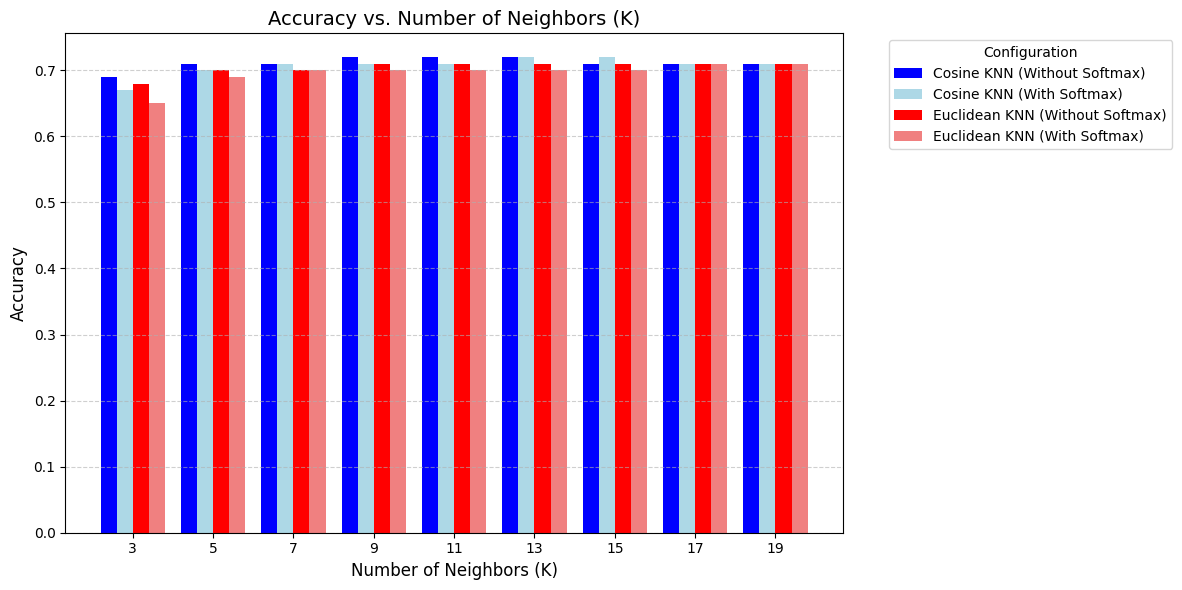

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19]

# Cosine KNN results
cosine_without_softmax = [0.69, 0.71, 0.71, 0.72, 0.72, 0.72, 0.71, 0.71, 0.71]
cosine_with_softmax = [0.67, 0.70, 0.71, 0.71, 0.71, 0.72, 0.72, 0.71, 0.71]

# Euclidean KNN results
euclidean_without_softmax = [0.68, 0.70, 0.70, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71]
euclidean_with_softmax = [0.65, 0.69, 0.70, 0.70, 0.70, 0.70, 0.70, 0.71, 0.71]

# Set up the plot
plt.figure(figsize=(12, 6))

# Bar width
bar_width = 0.2
x = np.arange(len(k_values))  # x-axis positions

# Plot bars
plt.bar(x - 1.5 * bar_width, cosine_without_softmax, width=bar_width, color='blue', label='Cosine KNN (Without Softmax)')
plt.bar(x - 0.5 * bar_width, cosine_with_softmax, width=bar_width, color='lightblue', label='Cosine KNN (With Softmax)')
plt.bar(x + 0.5 * bar_width, euclidean_without_softmax, width=bar_width, color='red', label='Euclidean KNN (Without Softmax)')
plt.bar(x + 1.5 * bar_width, euclidean_with_softmax, width=bar_width, color='lightcoral', label='Euclidean KNN (With Softmax)')

# Add labels and title
plt.title('Accuracy vs. Number of Neighbors (K)', fontsize=14)
plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(x, k_values)  # Set x-ticks to K values
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

# Add legend
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

# Results

## CLS

| **K** | **Accuracy** | **Use Softmax Predictions** | **Similarity** | **K** | **Accuracy** | **Use Softmax Predictions** | **Similarity** |
|-------|--------------|-----------------------------|-----------------|-------|--------------|-----------------------------|-----------------|
| 3     | 0.69         | FALSE                       | Cosine          | 3     | 0.68         | FALSE                       | Cosine          |
| 5     | 0.71         | FALSE                       | Cosine          | 5     | 0.70         | FALSE                       | Cosine          |
| 7     | 0.71         | FALSE                       | Cosine          | 7     | 0.70         | FALSE                       | Cosine          |
| 9     | 0.72         | FALSE                       | Cosine          | 9     | 0.71         | FALSE                       | Cosine          |
| 11    | 0.72         | FALSE                       | Cosine          | 11    | 0.71         | FALSE                       | Cosine          |
| 13    | 0.72         | FALSE                       | Cosine          | 13    | 0.71         | FALSE                       | Cosine          |
| 15    | 0.71         | FALSE                       | Cosine          | 15    | 0.71         | FALSE                       | Cosine          |
| 17    | 0.71         | FALSE                       | Cosine          | 17    | 0.71         | FALSE                       | Cosine          |
| 19    | 0.71         | FALSE                       | Cosine          | 19    | 0.71         | FALSE                       | Cosine          |
| 3     | 0.67         | TRUE                        | Cosine          | 3     | 0.65         | TRUE                        | Cosine          |
| 5     | 0.70         | TRUE                        | Cosine          | 5     | 0.69         | TRUE                        | Cosine          |
| 7     | 0.71         | TRUE                        | Cosine          | 7     | 0.70         | TRUE                        | Cosine          |
| 9     | 0.71         | TRUE                        | Cosine          | 9     | 0.70         | TRUE                        | Cosine          |
| 11    | 0.71         | TRUE                        | Cosine          | 11    | 0.70         | TRUE                        | Cosine          |
| 13    | 0.72         | TRUE                        | Cosine          | 13    | 0.70         | TRUE                        | Cosine          |
| 15    | 0.72         | TRUE                        | Cosine          | 15    | 0.70         | TRUE                        | Cosine          |
| 17    | 0.71         | TRUE                        | Cosine          | 17    | 0.71         | TRUE                        | Cosine          |
| 19    | 0.71         | TRUE                        | Cosine          | 19    | 0.71         | TRUE                        | Cosine          |

Observations:
Embeddings Produced with Cosine vs Euclidean KNN

 - The embeddings produced by the KNN with the Cosine similarity consistently outperforms the ones created with the  Euclidean similarity across all values of K and configurations (with or without SoftMax predictions). 

Effect of Number of Neighbors (K):

 - As K increases, accuracy improves slightly, peaking around K=9 or K=11, after which it slightly decreases.

 - This is expected because a small K can be noisy, while a very large K may include irrelevant neighbors, reducing accuracy.

Use of Softmax Predictions:

 - When softmax predictions are used (Use Softmax Predictions = TRUE), accuracy is generally slightly lower compared to when they are not used (FALSE) but accuracy value has the same upper thereshold (72%).

 - This is surprising because the softmax predictions come from a model with ~76% accuracy, which should theoretically improve results. The slight drop suggests that the softmax predictions might not align well with the KNN-based distance sums.

Accuracy Comparison to Base Model:

 - The best accuracy 0.72 achieved with cosine, K=9 or K=11 is lower than the base model's ~76% accuracy.

 - This indicates that the function approach, while reasonable, is not as effective as the base model for this task

Key Takeaways:
 - Cosine similarity with K=9 or K=11 and without softmax predictions performs the best, achieving 72% accuracy.

 - The softmax predictions do not improve results in this setup, suggesting they might need better integration or weighting.

 - The prediction with function approach underperforms compared to the base model (~76% accuracy), indicating that either:

    - The embeddings are not ideal for the function.

    - The function prediction method needs refinement (e.g., better distance weighting or neighbor selection).

# Patch

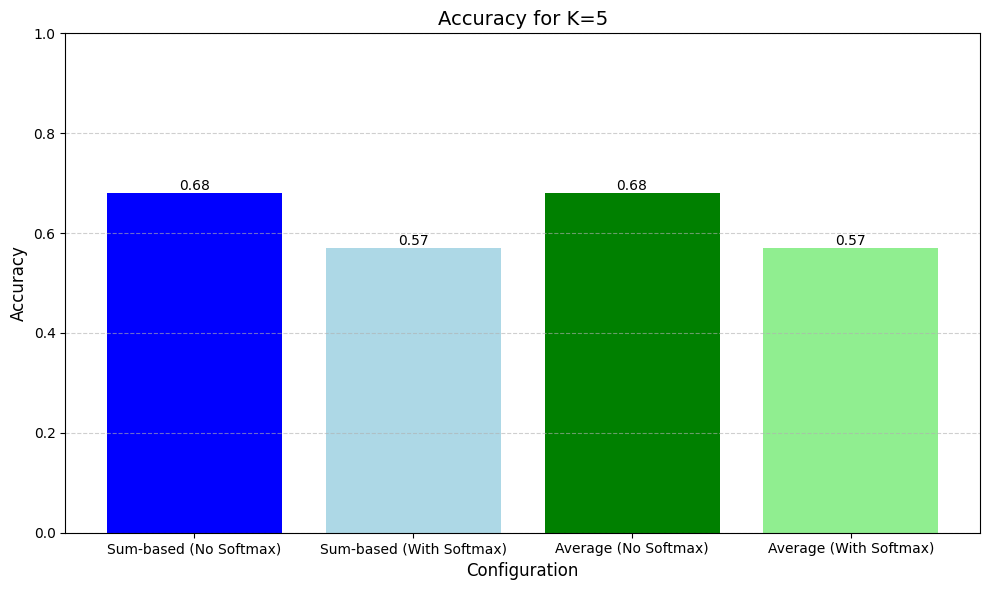

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_value = 5  # Fixed K value
configurations = ['Sum-based (No Softmax)', 'Sum-based (With Softmax)', 'Average (No Softmax)', 'Average (With Softmax)']
accuracies = [0.68, 0.57, 0.68, 0.57]

# Set up the plot
plt.figure(figsize=(10, 6))

# Bar colors
colors = ['blue', 'lightblue', 'green', 'lightgreen']

# Plot bars
bars = plt.bar(configurations, accuracies, color=colors)

# Add labels and title
plt.title(f'Accuracy for K={k_value}', fontsize=14)
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

- The results show that incorporating softmax predictions reduces accuracy from 0.68 to 0.57, regardless of whether sum-based or average weighting is used.

- This suggests that softmax probabilities may be poorly calibrated or introduce noise when weighting nearest neighbors.

- Moreover, the choice between sum-based and average weighting has minimal impact, as both yield the same accuracy without softmax predictions.

- The accuracy drop with softmax weighting indicates a misalignment between predicted probabilities and the similarity-based approach, possibly due to incorrect predictions or overconfidence.

- Further investigation into softmax calibration, adjusting the static distance factor and exploring alternative distance metrics or a larger K value could help improve performance.

# Best Models Comparison

| Accuracy | Model Type      | K  | Similarity | Use Softmax Predictions | Weighting       |
|----------|-----------------|----|------------|--------------------------|-----------------|
| 0.7657   | Fine Tune       | -  | -          | -                        | -               |
| 0.72     | Knn - Cls       | 9, 11, 13  | Cosine     | -                        | -               |
| 0.7      | Knn - Patch     | 5  | Cosine     | -                        | -               |
| 0.72     | Function - Cls  | 9  | Cosine     | FALSE                    | -               |
| 0.68     | Function - Patch| 5  | Cosine     | FALSE                    | Average/Sum-based |


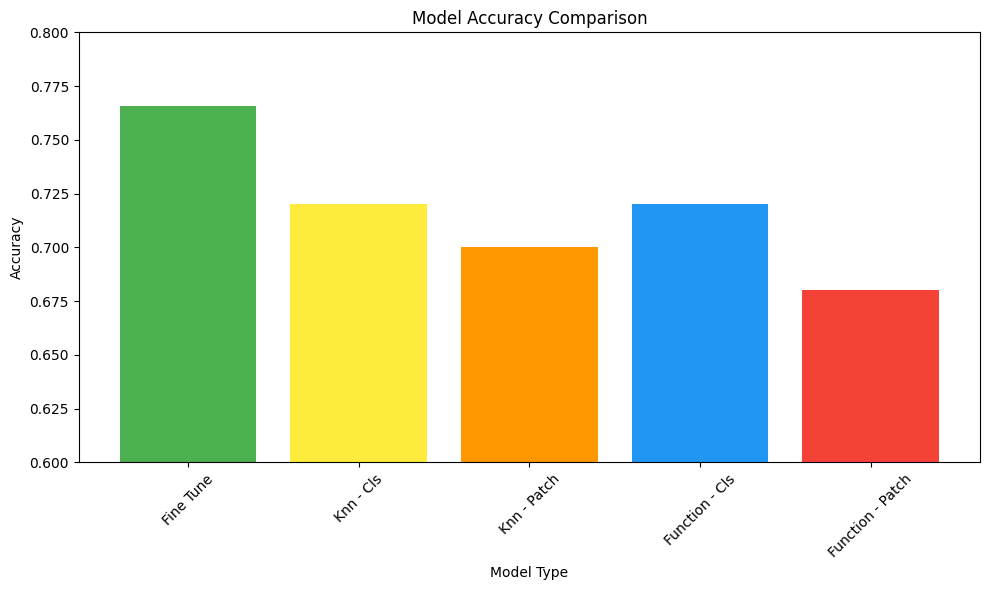

In [142]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the plot
data = {
    "Accuracy": [0.7657, 0.72, 0.7, 0.72, 0.68],
    "Model Type": ["Fine Tune", "Knn - Cls", "Knn - Patch", "Function - Cls", "Function - Patch"],
    "K": ["-", "9, 11, 13", "5", "9, 11", "5"],
    "Similarity": ["-", "Cosine", "Cosine", "Cosine", "Cosine"],
    "Use Softmax Predictions": ["-", "-", "-", "FALSE", "FALSE"],
    "Weighting": ["-", "-", "-", "-", "Average/Sum-based"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df["Model Type"], df["Accuracy"], color=['#4CAF50', '#FFEB3B', '#FF9800', '#2196F3', '#F44336'])
plt.xlabel("Model Type")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.6, 0.8)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


- Fine-tuning outperforms all other methods (0.7657), suggesting that training the model directly on the dataset allows it to learn better feature representations compared to other approaches.

- The brute force KNN has similar behavior with the Function prediction method.

- Using bruteforce KNN and the prediction function with CLS embeddings and cosine similarity achieves 0.72 accuracy with K values of 9, 11, and 13.

- When using patch embeddings instead, the accuracy drops slightly.

- This suggests that while local patch-level information is useful, it may not be as discriminative as CLS embeddings for final classification.

- The weighting method (sum-based or average) does not significantly impact performance in the patch-based approach.

Key Takeaways:
 - Fine-tuning provides the best performance, likely due to better feature extraction and task-specific adaptation.
 - The brute force KNN performs similar to the Function prediction method.
 - CLS embeddings work better than patch-based embeddings for classification.
 - Higher K values (9-13) improve KNN performance by reducing noise (up to a threshold).
 - Using softmax weighting in previous experiments may have hurt performance, but here it was not explicitly tested.